In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pydicom
import nibabel as nib
import ast

import os
import cv2

import SimpleITK as sitk
from concurrent.futures import ThreadPoolExecutor
from collections import Counter
import plotly.graph_objects as go

In [2]:
labels = [
    "BG",
"Other Posterior Circulation",
"Basilar Tip",
"R Posterior Communicating Artery",
"L Posterior Communicating Artery",
"R Infraclinoid Internal Carotid Artery",
"L Infraclinoid Internal Carotid Artery",
"R Supraclinoid Internal Carotid Artery",
"L Supraclinoid Internal Carotid Artery",
"R Middle Cerebral Artery",
"L Middle Cerebral Artery",
"R Anterior Cerebral Artery",
"L Anterior Cerebral Artery",
"Anterior Communicating Artery"

]

In [3]:
traindf = pd.read_csv("/kaggle/input/rsna-intracranial-aneurysm-detection/train.csv")
labeldf = pd.read_csv("/kaggle/input/rsna-intracranial-aneurysm-detection/train_localizers.csv")

In [4]:

uid = '1.2.826.0.1.3680043.8.498.10076056930521523789588901704956188485'
niipath = f"/kaggle/input/rsna-intracranial-aneurysm-detection/segmentations/{uid}_cowseg.nii"

label = nib.load(niipath)
label.get_fdata().shape

(1024, 1024, 136)

In [5]:
traindf[traindf["SeriesInstanceUID"] == uid]

,SeriesInstanceUID,PatientAge,PatientSex,Modality,Left Infraclinoid Internal Carotid Artery,Right Infraclinoid Internal Carotid Artery,Left Supraclinoid Internal Carotid Artery,Right Supraclinoid Internal Carotid Artery,Left Middle Cerebral Artery,Right Middle Cerebral Artery,Anterior Communicating Artery,Left Anterior Cerebral Artery,Right Anterior Cerebral Artery,Left Posterior Communicating Artery,Right Posterior Communicating Artery,Basilar Tip,Other Posterior Circulation,Aneurysm Present
27,1.2.826.0.1.3680043.8.498.10076056930521523789...,40,Female,MRA,0,0,0,1,0,0,0,0,0,0,0,0,0,1


In [6]:
def get_label_coords(uid):
    
    l = ast.literal_eval(labeldf[labeldf["SeriesInstanceUID"] == uid].coordinates.iloc[0])
    suid = labeldf[labeldf["SeriesInstanceUID"] == uid].SOPInstanceUID.iloc[0]

    ds = pydicom.dcmread(f"/kaggle/input/rsna-intracranial-aneurysm-detection/series/{uid}/{suid}.dcm")
    
    return int(l["x"]),int(l["y"]), int(ds.InstanceNumber)


def load_series2vol(series_path, series_id=None, spacing_tolerance=1e-3, resample=False, default_thickness=1.0, max_workers=20):
    reader = sitk.ImageSeriesReader()

    # Get all series IDs
    series_ids = reader.GetGDCMSeriesIDs(series_path)
    if not series_ids:
        raise RuntimeError(f"No DICOM series found in {series_path}")

    # Pick first if not specified
    series_id = str(series_ids[0] if series_id is None else series_id)

    # Get file names for the series
    all_files = reader.GetGDCMSeriesFileNames(series_path, series_id)

    # --- Parallel metadata read (fast size check) ---
    def get_size(f):
        ds = pydicom.dcmread(f, stop_before_pixels=True)
        return (int(ds.Rows), int(ds.Columns)), f

    with ThreadPoolExecutor(max_workers=max_workers) as ex:
        sizes = list(ex.map(get_size, all_files))

    # Pick the most common size
    most_common_size = Counter(s[0] for s in sizes).most_common(1)[0][0]
    files = [f for (sz, f) in sizes if sz == most_common_size]

    # --- Now read the actual image series ---
    reader.SetFileNames(files)
    image = reader.Execute()

    # --- Fix zero thickness ---
    spacing = list(image.GetSpacing())
    if spacing[2] == 0:
        spacing[2] = default_thickness
        image.SetSpacing(spacing)

    # --- Optional resample ---
    if resample and abs(spacing[2] - spacing[0]) > spacing_tolerance:
        print("resampling....")
        new_spacing = [spacing[0], spacing[1], spacing[0]]
        new_size = [
            int(round(image.GetSize()[0] * spacing[0] / new_spacing[0])),
            int(round(image.GetSize()[1] * spacing[1] / new_spacing[1])),
            int(round(image.GetSize()[2] * spacing[2] / new_spacing[2]))
        ]
        resampler = sitk.ResampleImageFilter()
        resampler.SetOutputSpacing(new_spacing)
        resampler.SetSize(new_size)
        resampler.SetOutputDirection(image.GetDirection())
        resampler.SetOutputOrigin(image.GetOrigin())
        resampler.SetInterpolator(sitk.sitkLinear)
        image = resampler.Execute(image)

    # Convert to numpy array
    volume = sitk.GetArrayFromImage(image)
    return volume

def view_nii_segmentation(uid, mip, file_path: str, flip=False):
    """
    Loads and creates a static 2D view of a .nii segmentation.

    Args:
        uid: identifier (used for label coords).
        file_path (str): Path to the .nii or .nii.gz file.
        flip (bool): Whether to flip the Y-axis.
    """
    nii_image = nib.load(file_path)
    data = nii_image.get_fdata()

    print(f"Image dimensions: {data.shape}")
    unique_labels = np.unique(data)
    print(f"Found labels: {unique_labels}")


    # Plot the MIP as grayscale
    plt.figure(figsize=(6, 6))
    plt.imshow(mip, cmap="gray")

    # Overlay label markers
    for label_value in unique_labels:
        if label_value == 0:  # skip background
            continue
        x, y, z = np.where(data == label_value)
        x = x[::5]
        y = y[::5]
        z = z[::5] 
        if flip: 
            y = data.shape[1] - y
            
        plt.scatter(x, y, s=1, label=f"{labels[int(label_value)]}", alpha=0.6)

    # Overlay additional label coords
    lx, ly, lz = get_label_coords(uid)

    plt.scatter([lx], [ly], c="red", s=20, label="Label Coord", marker="x")

    plt.title("Segmentation MIP")
    plt.axis("off")
    plt.legend(loc="upper right", fontsize=6)
    plt.tight_layout()
    plt.show()

In [7]:

vol = load_series2vol(f"/kaggle/input/rsna-intracranial-aneurysm-detection/series/{uid}", uid)

ImageSeriesReader (0x40b4fd50): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.000101863



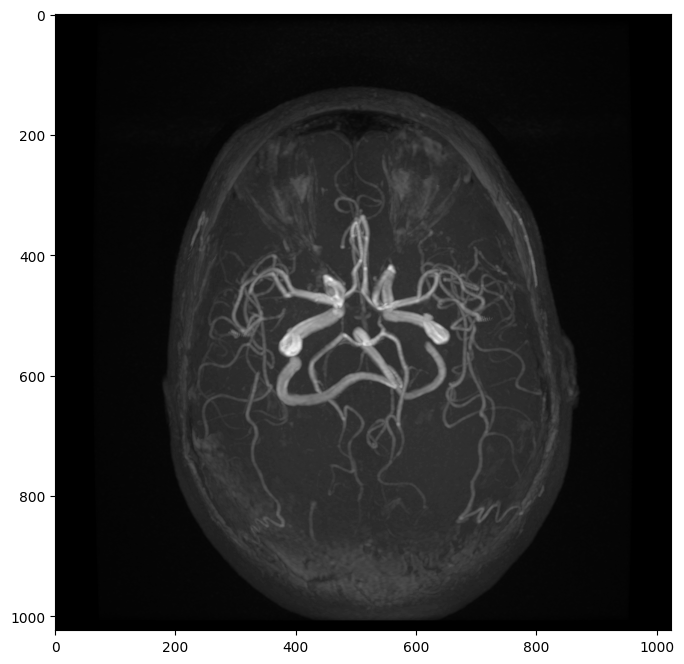

In [8]:
mip = vol.max(axis=0)

plt.figure(figsize=(8,8))
plt.imshow(mip, cmap="gray")

Image dimensions: (1024, 1024, 136)
Found labels: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13.]


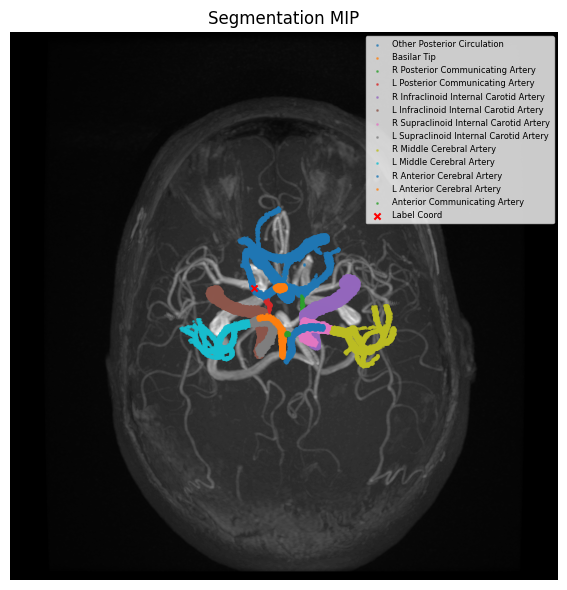

In [9]:
view_nii_segmentation(uid,mip,niipath)

Segmentation and the MIP vessels doesn't overlap properly

Image dimensions: (1024, 1024, 136)
Found labels: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13.]


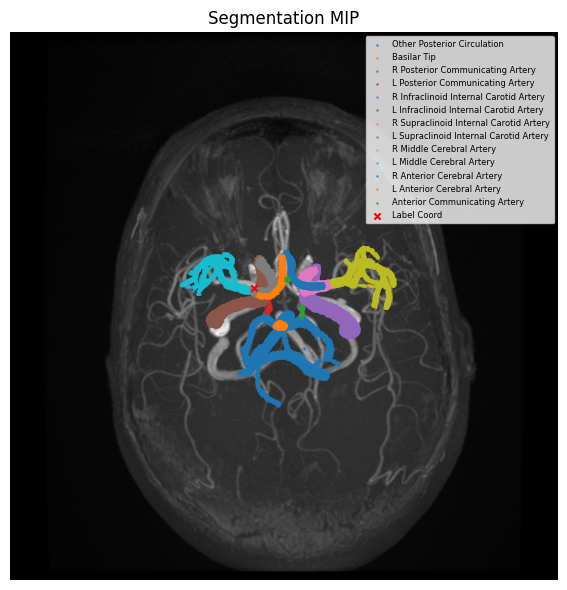

In [10]:
view_nii_segmentation(uid,mip,niipath,flip=True)

But after fliping the segmentation in y-axis they begin to overlap!